In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data
from localgraphclustering import *

import sys
sys.path.append("../")
    
from affinity_kimon import affinity
from skimage.color import rgb2gray
from skimage import data, segmentation, color
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from skimage.future import graph
from skimage.segmentation import mark_boundaries
from skimage.io import imread
from skimage import data

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import networkx as nx

import warnings
warnings.filterwarnings('ignore')

## JH, groundtruth 

Text(0.5, 0.85, 'year 2009')

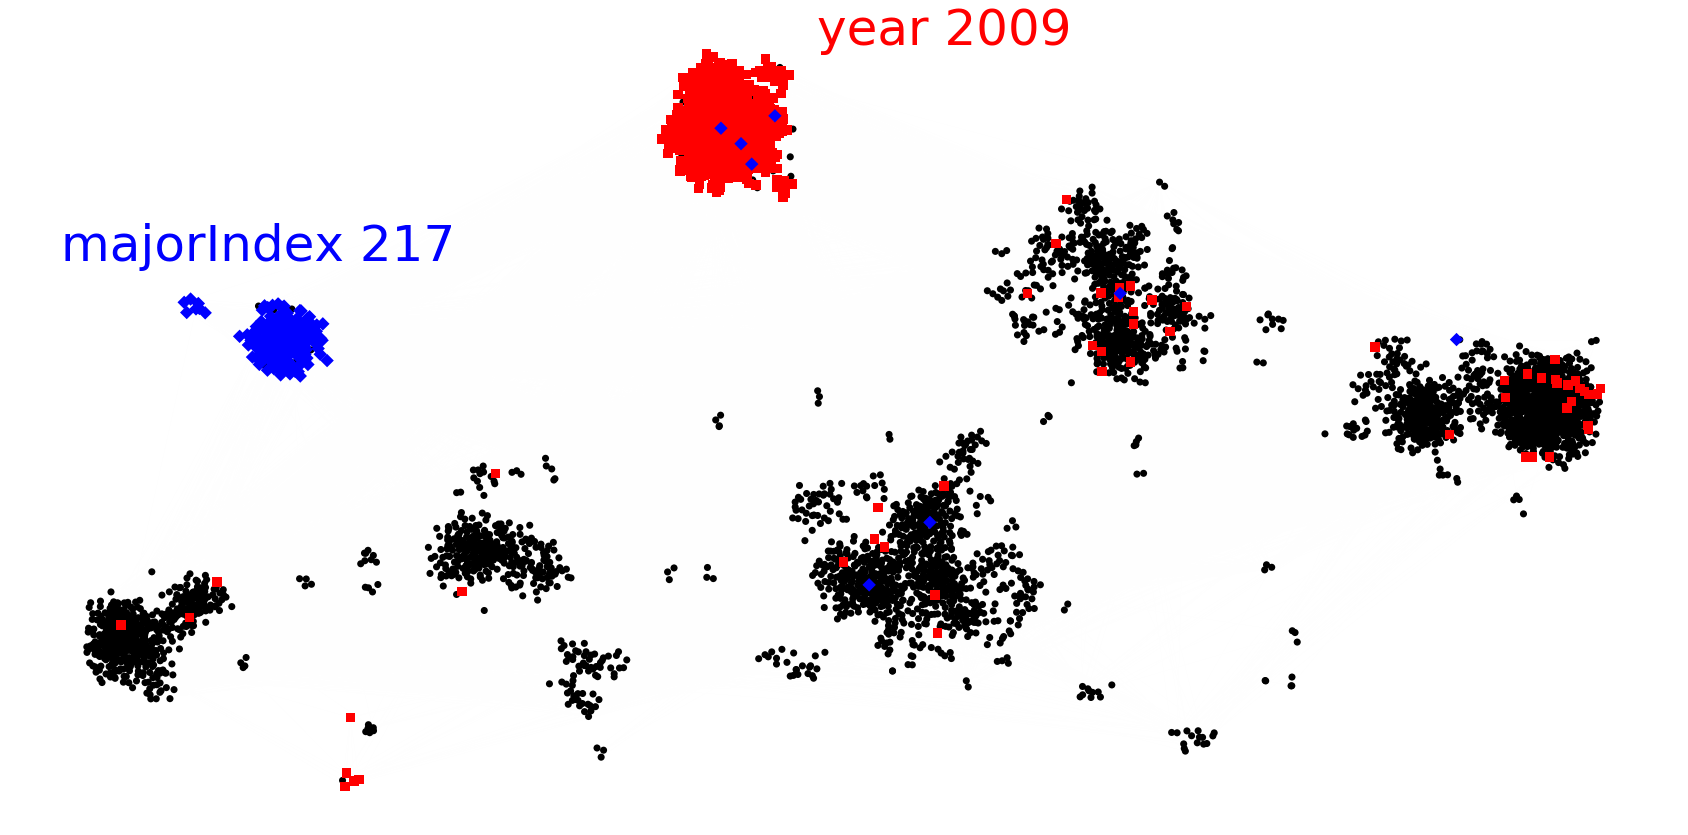

In [2]:
g = GraphLocal('../datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml('../datasets/JohnsHopkins.graphml')

target_cluster = []
counter = 0
for node in g_nx.nodes():
    if g_nx.node[node]['year'] == 2009.0:
        target_cluster.append(counter)
    counter += 1
    
target_cluster2 = []
counter = 0
for node in g_nx.nodes():
    if g_nx.node[node]['majorIndex'] == 217.0:
        target_cluster2.append(counter)
    counter += 1
    
ld_coord = np.loadtxt('../datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
node_colors = ['black' for i in range(g._num_vertices)]
for i in target_cluster:
    node_colors[i] = 'red'
for i in target_cluster2:
    node_colors[i] = 'blue'

temp = np.ones(g._num_vertices)
temp[target_cluster] = 4
temp[target_cluster2] = 4

nodesize_list = 50*np.ones(g._num_vertices)
nodesize_list[target_cluster] = 90
nodesize_list[target_cluster2] = 90

nodemarker_list = ['o'] * g._num_vertices
for i in target_cluster:
    nodemarker_list[i] = 's'
for i in target_cluster2:
    nodemarker_list[i] = 'D'
    
nodeorder_list = [1 for i in range(g._num_vertices)]
for i in target_cluster:
    nodeorder_list[i] = 2
for i in target_cluster2:
    nodeorder_list[i] = 3

drawing = g.draw_groups(pos,temp,figsize=(30,15),edgealpha=0.003,node_color_list=node_colors,nodesize_list=nodesize_list,nodemarker_list=nodemarker_list,nodeorder_list=nodeorder_list)

drawing.fig.text(0.15, 0.65, 'majorIndex 217', fontsize=50, color='blue')
drawing.fig.text(0.5, 0.85, 'year 2009', fontsize=50, color='red')

# drawing.fig.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_targetclusters.png', format='png',bbox_inches='tight')

## JH graph, year 2009, MQI

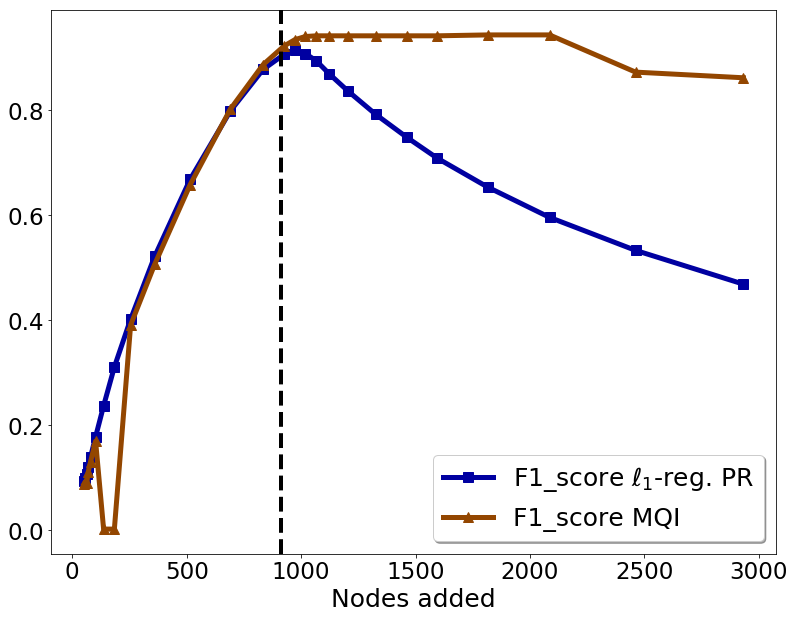

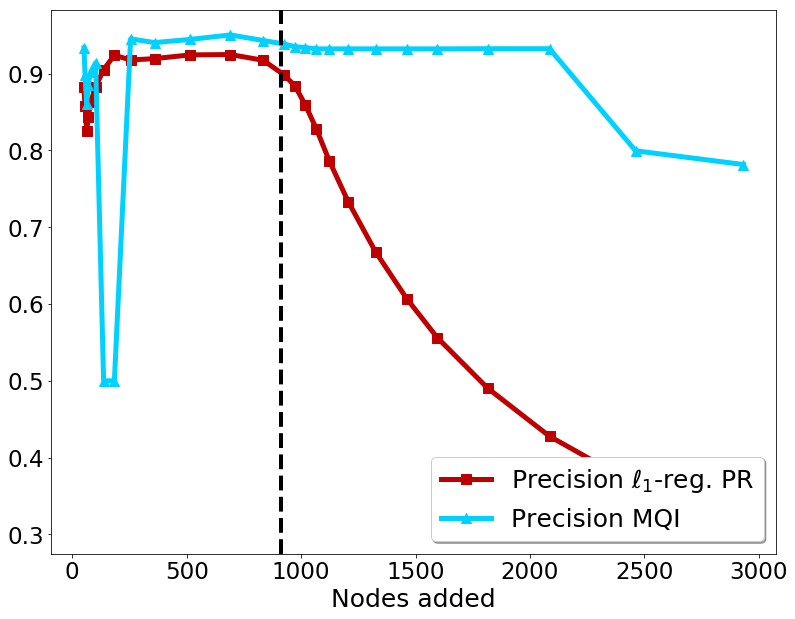

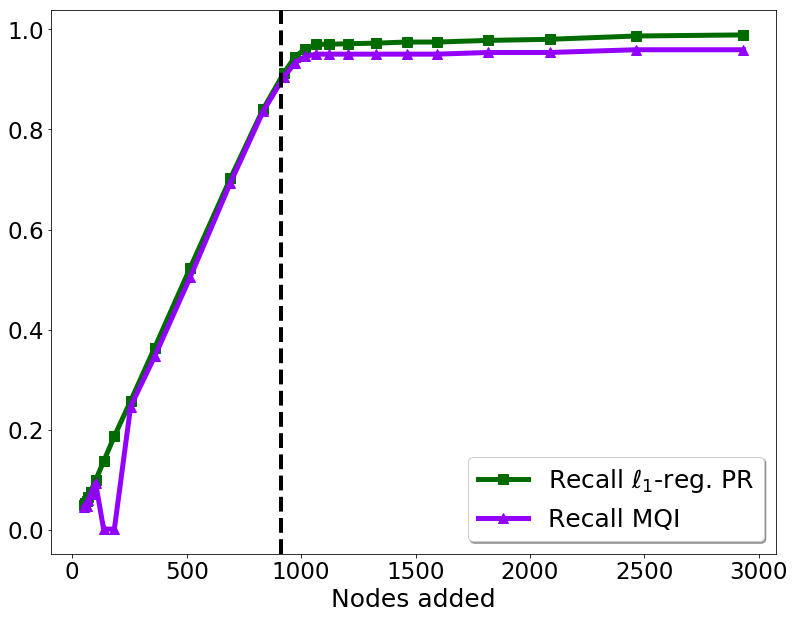

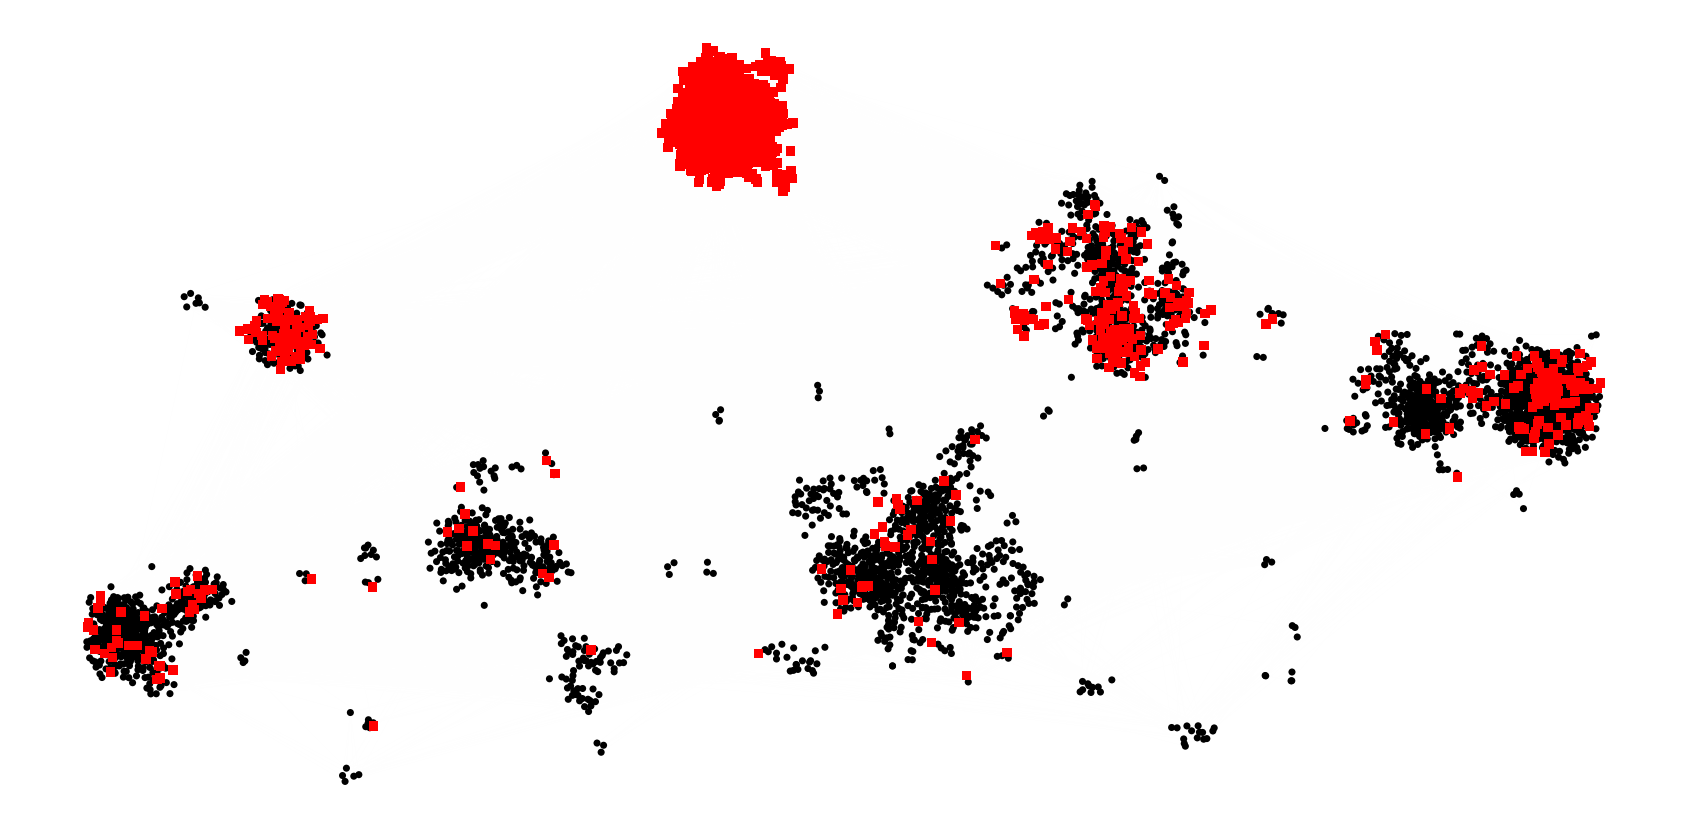

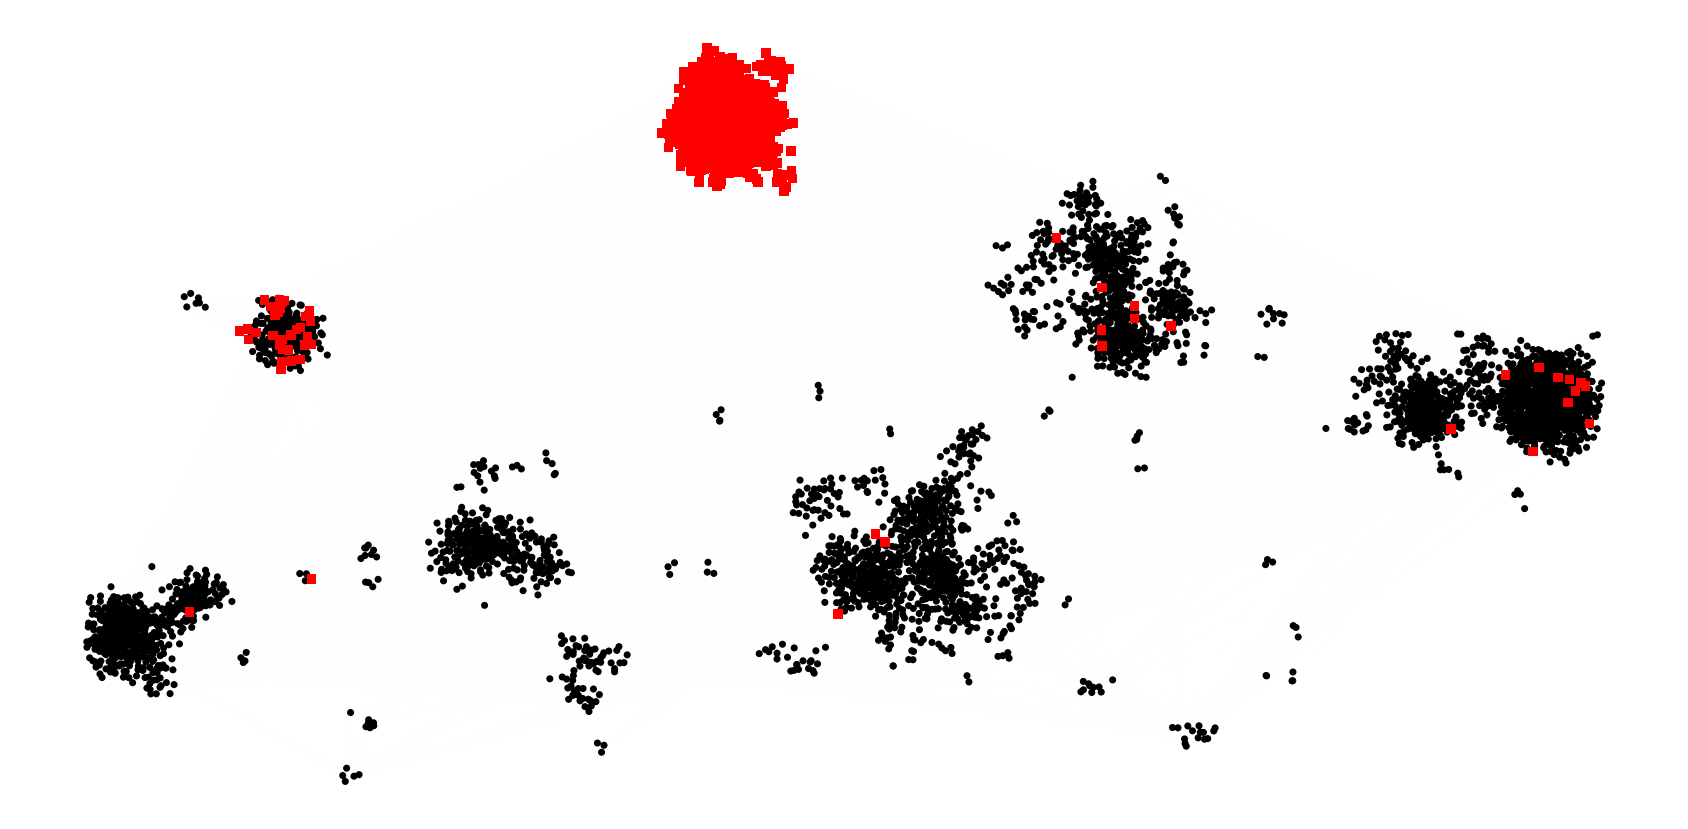

In [3]:
g = GraphLocal('../datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml('../datasets/JohnsHopkins.graphml')

target_cluster = []
counter = 0
for node in g_nx.nodes():
    if g_nx.node[node]['year'] == 2009.0:
        target_cluster.append(counter)
    counter += 1
    
ld_coord = np.loadtxt('../datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]

# Set teleportation parameter
alpha = g.compute_conductance(target_cluster)**2

# Set reference node for algorithm
ref_node = target_cluster[0]

d = g.d
n = g._num_vertices

# Stagewise algorithm
start = time.time()

Conductance = []
TPR = []
FPR = []
FDR = []
Pos_Size = []
F1score = []
Precision = []
Recall = []

Conductance_mqi = []
TPR_mqi = []
FPR_mqi = []
FDR_mqi = []
Pos_Size_mqi = []
F1score_mqi = []
Precision_mqi = []
Recall_mqi = []

vol_G = np.sum(g.d)

rho_list = list(np.geomspace(1.0e-4, 1.0e-18, 200, endpoint=True))

cardinalities = []

counter = 1

for rho in rho_list:

    output = approximate_PageRank(g,ref_node,method='l1reg-rand',alpha=alpha,rho=rho,normalize=False,normalized_objective=False,epsilon=1.0e-10,iterations=1000000,cpp=True)
    recovered_cluster = output[0]
        
    recovered_cluster_sweep = recovered_cluster #sweep_cut(g,(output[0],output[1]))[0]
    
    cardinalities.append(len(recovered_cluster))

    output_mqi = flow_clustering(g,recovered_cluster_sweep,method="mqi")[0]

    conductance = g.compute_conductance(recovered_cluster_sweep)
    Conductance.append(conductance)

    conductance = g.compute_conductance(output_mqi)
    Conductance_mqi.append(conductance)

    true_pos = np.intersect1d(recovered_cluster_sweep, target_cluster)
    true_pos_rate = len(true_pos)/len(target_cluster)

    true_pos_mqi = np.intersect1d(output_mqi, target_cluster)
    true_pos_rate_mqi = len(true_pos_mqi)/len(target_cluster)

    false_pos = np.setdiff1d(recovered_cluster_sweep, target_cluster)
    if len(recovered_cluster_sweep) == 0:
        false_disc_rate = len(false_pos)
    else:
        false_disc_rate = len(false_pos)/len(recovered_cluster_sweep)
    false_pos_rate = len(false_pos)/(n-len(target_cluster))

    false_pos_mqi = np.setdiff1d(output_mqi, target_cluster)
    if len(output_mqi) == 0:
        false_disc_rate_mqi = len(false_pos_mqi)
    else:
        false_disc_rate_mqi = len(false_pos_mqi)/len(output_mqi)
    false_pos_rate_mqi = len(false_pos_mqi)/(n-len(target_cluster))

    TPR.append(true_pos_rate)
    FDR.append(false_disc_rate)
    FPR.append(false_pos_rate)
    Pos_Size.append(len(recovered_cluster_sweep)) 
    temp = np.zeros(n)
    temp[recovered_cluster_sweep] = 1
    temp2 = np.zeros(n)
    temp2[target_cluster] = 1
    F1score.append(f1_score(temp2,temp))
    Precision.append(precision_score(temp2,temp))
    Recall.append(recall_score(temp2,temp))

    TPR_mqi.append(true_pos_rate_mqi)
    FDR_mqi.append(false_disc_rate_mqi)
    FPR_mqi.append(false_pos_rate_mqi)
    Pos_Size_mqi.append(len(output_mqi))   
    temp = np.zeros(n)
    temp[output_mqi] = 1
    temp2 = np.zeros(n)
    temp2[target_cluster] = 1
    F1score_mqi.append(f1_score(temp2,temp))
    Precision_mqi.append(precision_score(temp2,temp))
    Recall_mqi.append(recall_score(temp2,temp))
    
    if counter == 20:
        store_spectral = recovered_cluster_sweep
        store_mqi = output_mqi
        
    if true_pos_rate >0.9999999:
        break
        
    if np.sum(g.d[recovered_cluster]) > g.vol_G/2:
        break
    
    counter += 1

end = time.time()

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, F1score, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, F1score_mqi, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_f1score_plots_2009.pdf', format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, Precision, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, Precision_mqi, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_precision_plots_2009.pdf', format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, Recall, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, Recall_mqi, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_recall_plots_2009.pdf', format='pdf',bbox_inches='tight')

temp = np.ones(g._num_vertices)
temp[store_spectral] = 2

node_colors = ['black' for i in range(g._num_vertices)]
for i in store_spectral:
    node_colors[i] = 'red'

nodesize_list = 50*np.ones(g._num_vertices)
nodesize_list[store_spectral] = 90

nodemarker_list = ['o'] * g._num_vertices
for i in store_spectral:
    nodemarker_list[i] = 's'
    
nodeorder_list = [1 for i in range(g._num_vertices)]
for i in store_spectral:
    nodeorder_list[i] = 2

drawing = g.draw_groups(pos,temp,figsize=(30,15),edgealpha=0.003,node_color_list=node_colors,nodesize_list=nodesize_list,nodemarker_list=nodemarker_list,nodeorder_list=nodeorder_list)

# drawing.fig.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_input_2009.png', format='png',bbox_inches='tight')

node_colors = ['black' for i in range(g._num_vertices)]
for i in store_mqi:
    node_colors[i] = 'red'

temp = np.ones(g._num_vertices)
temp[store_mqi] = 4

nodesize_list = 50*np.ones(g._num_vertices)
nodesize_list[store_mqi] = 90

nodemarker_list = ['o'] * g._num_vertices
for i in store_mqi:
    nodemarker_list[i] = 's'
    
nodeorder_list = [1 for i in range(g._num_vertices)]
for i in store_mqi:
    nodeorder_list[i] = 2

drawing = g.draw_groups(pos,temp,figsize=(30,15),edgealpha=0.003,node_color_list=node_colors,nodesize_list=nodesize_list,nodemarker_list=nodemarker_list,nodeorder_list=nodeorder_list)

# drawing.fig.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_mqi_mqi_2009.png', format='png',bbox_inches='tight',nodeorder_list=nodeorder_list)

## JH, majorIndex 217, MQI

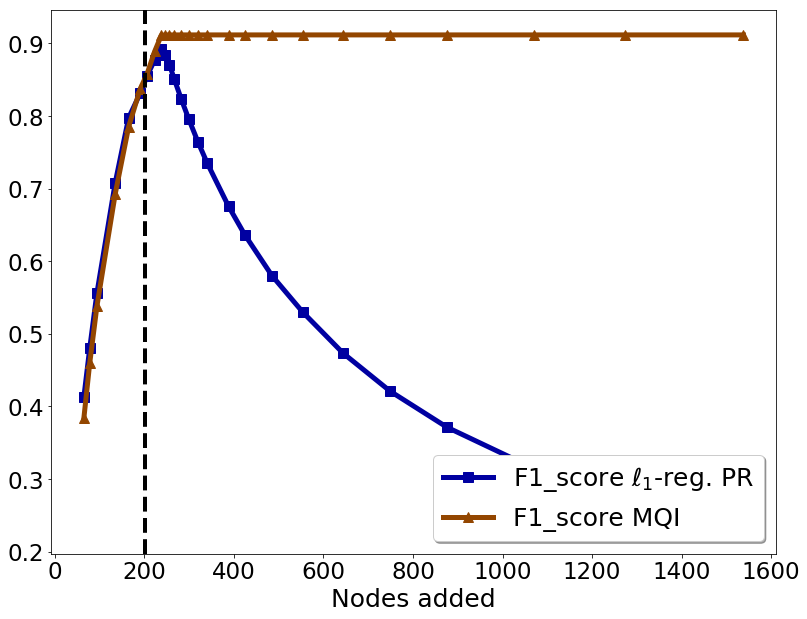

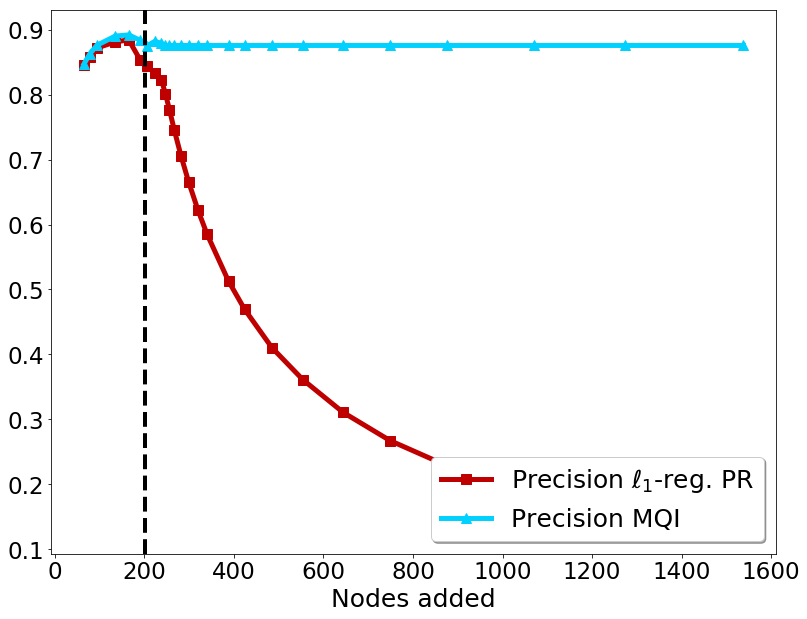

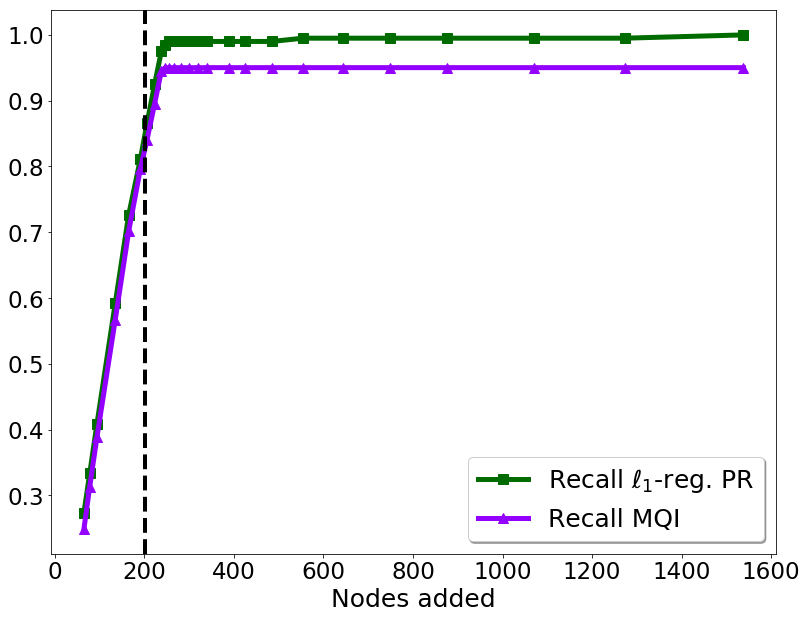

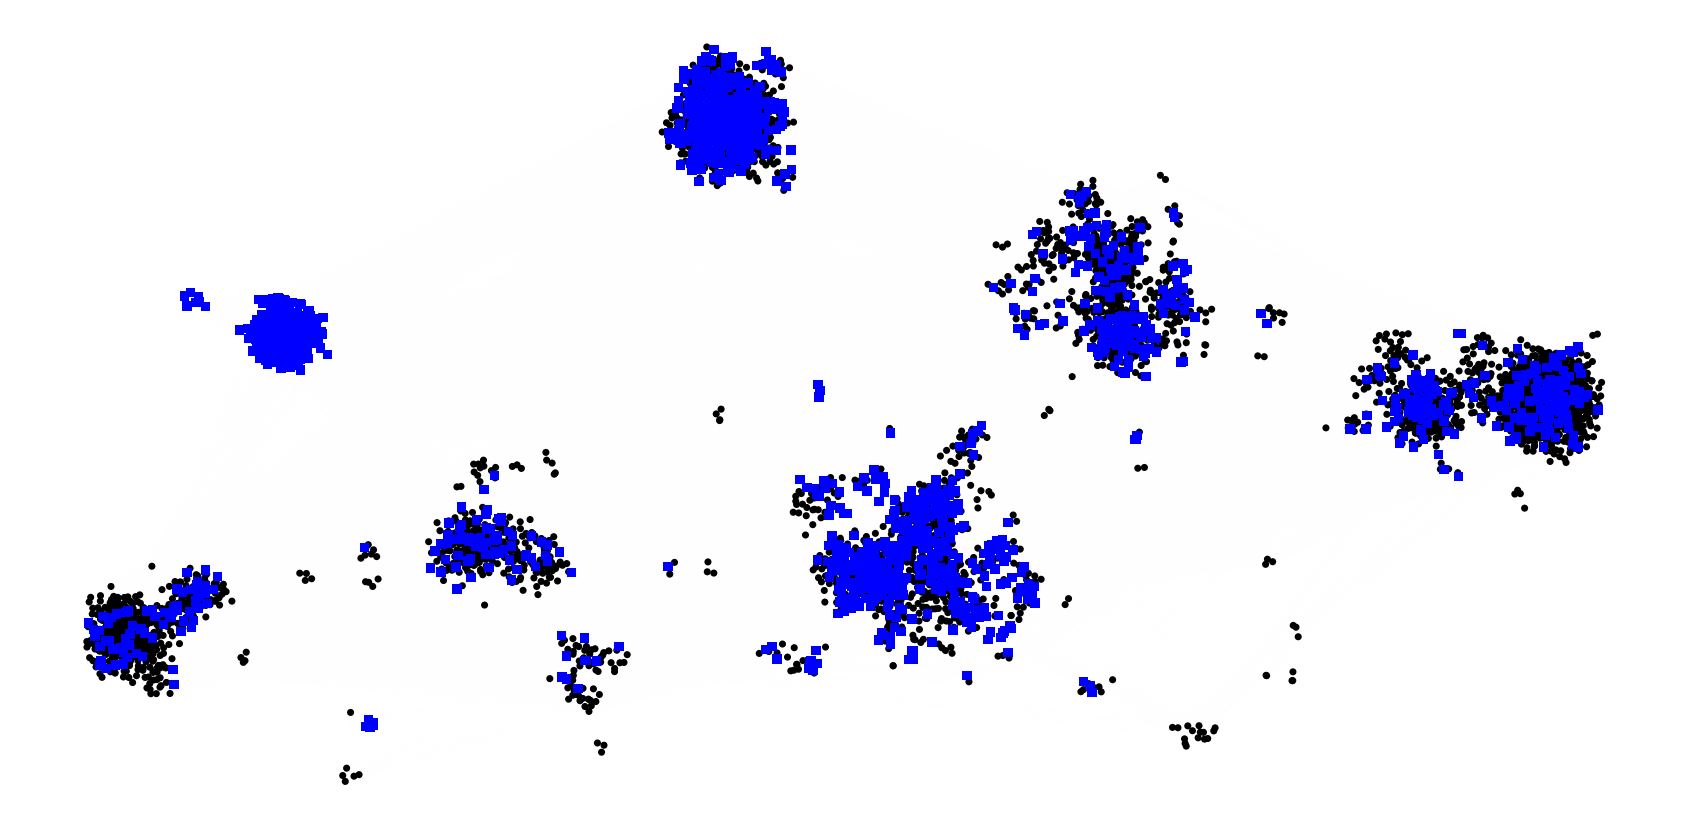

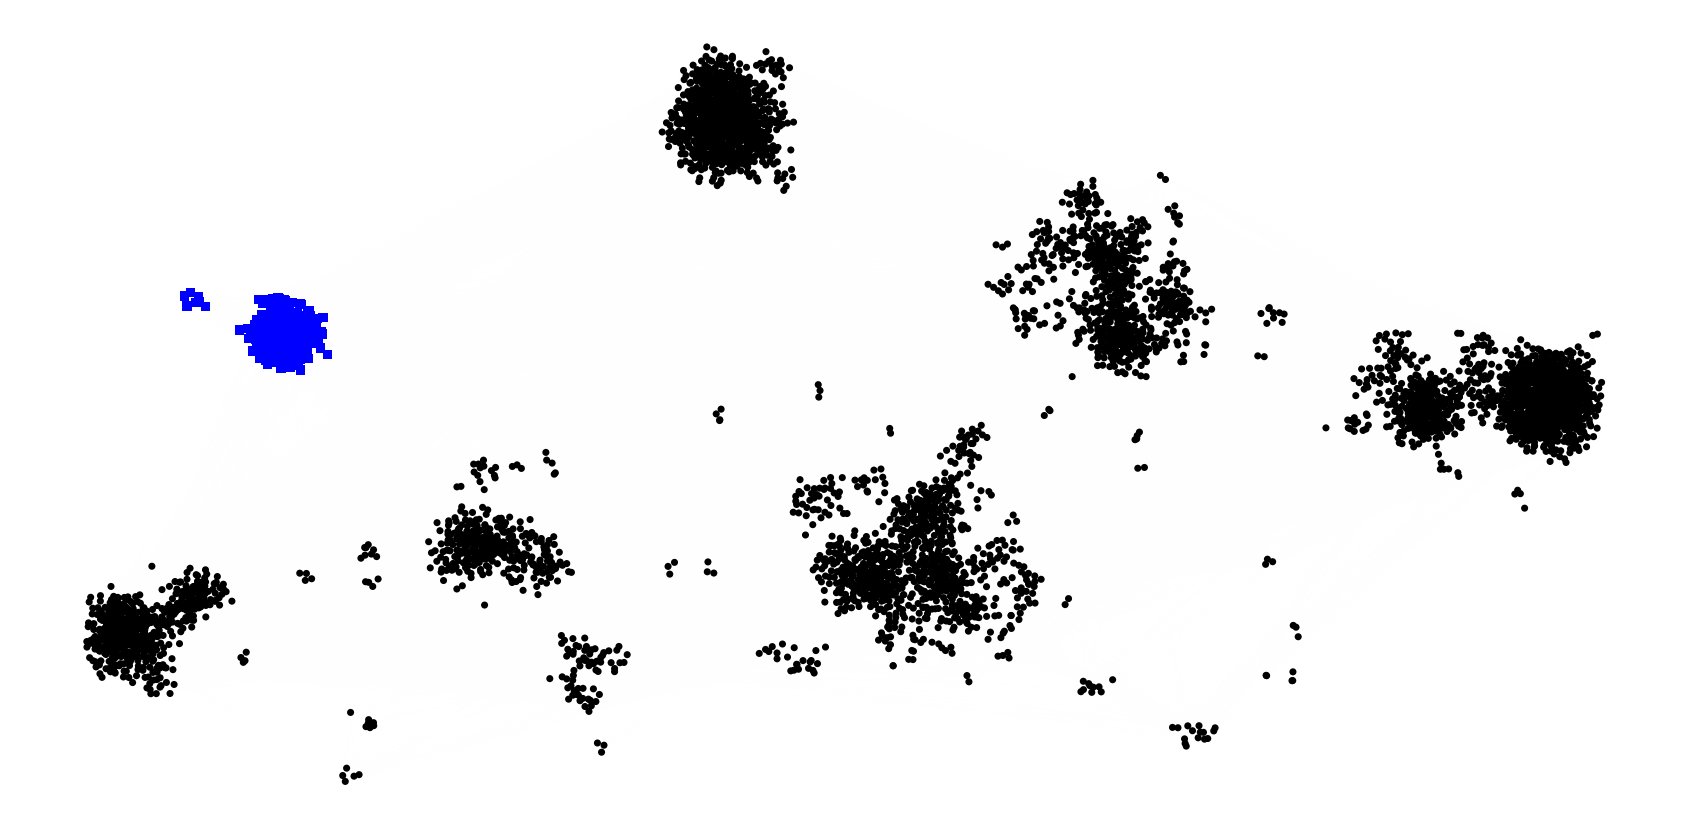

In [4]:
g = GraphLocal('../datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml('../datasets/JohnsHopkins.graphml')

target_cluster = []
counter = 0
for node in g_nx.nodes():
    if g_nx.node[node]['majorIndex'] == 217.0:
        target_cluster.append(counter)
    counter += 1
    
ld_coord = np.loadtxt('../datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]

# Set teleportation parameter
alpha = g.compute_conductance(target_cluster)**2

# Set reference node for algorithm
ref_node = target_cluster[0]

d = g.d
n = g._num_vertices

# Stagewise algorithm
start = time.time()

Conductance = []
TPR = []
FPR = []
FDR = []
Pos_Size = []
F1score = []
Precision = []
Recall = []

Conductance_mqi = []
TPR_mqi = []
FPR_mqi = []
FDR_mqi = []
Pos_Size_mqi = []
F1score_mqi = []
Precision_mqi = []
Recall_mqi = []

vol_G = np.sum(g.d)

rho_list = list(np.geomspace(1.0e-4, 1.0e-18, 200, endpoint=True))

cardinalities = []

counter = 1

for rho in rho_list:

    output = approximate_PageRank(g,ref_node,method='l1reg-rand',alpha=alpha,rho=rho,normalize=False,normalized_objective=False,epsilon=1.0e-10,iterations=1000000,cpp=True)
    recovered_cluster = output[0]
        
    recovered_cluster_sweep = recovered_cluster #sweep_cut(g,(output[0],output[1]))[0]
    
    cardinalities.append(len(recovered_cluster))

    output_mqi = flow_clustering(g,recovered_cluster_sweep,method="mqi")[0]

    conductance = g.compute_conductance(recovered_cluster_sweep)
    Conductance.append(conductance)

    conductance = g.compute_conductance(output_mqi)
    Conductance_mqi.append(conductance)

    true_pos = np.intersect1d(recovered_cluster_sweep, target_cluster)
    true_pos_rate = len(true_pos)/len(target_cluster)

    true_pos_mqi = np.intersect1d(output_mqi, target_cluster)
    true_pos_rate_mqi = len(true_pos_mqi)/len(target_cluster)

    false_pos = np.setdiff1d(recovered_cluster_sweep, target_cluster)
    if len(recovered_cluster_sweep) == 0:
        false_disc_rate = len(false_pos)
    else:
        false_disc_rate = len(false_pos)/len(recovered_cluster_sweep)
    false_pos_rate = len(false_pos)/(n-len(target_cluster))

    false_pos_mqi = np.setdiff1d(output_mqi, target_cluster)
    if len(output_mqi) == 0:
        false_disc_rate_mqi = len(false_pos_mqi)
    else:
        false_disc_rate_mqi = len(false_pos_mqi)/len(output_mqi)
    false_pos_rate_mqi = len(false_pos_mqi)/(n-len(target_cluster))

    TPR.append(true_pos_rate)
    FDR.append(false_disc_rate)
    FPR.append(false_pos_rate)
    Pos_Size.append(len(recovered_cluster_sweep)) 
    temp = np.zeros(n)
    temp[recovered_cluster_sweep] = 1
    temp2 = np.zeros(n)
    temp2[target_cluster] = 1
    F1score.append(f1_score(temp2,temp))
    Precision.append(precision_score(temp2,temp))
    Recall.append(recall_score(temp2,temp))

    TPR_mqi.append(true_pos_rate_mqi)
    FDR_mqi.append(false_disc_rate_mqi)
    FPR_mqi.append(false_pos_rate_mqi)
    Pos_Size_mqi.append(len(output_mqi))   
    temp = np.zeros(n)
    temp[output_mqi] = 1
    temp2 = np.zeros(n)
    temp2[target_cluster] = 1
    F1score_mqi.append(f1_score(temp2,temp))
    Precision_mqi.append(precision_score(temp2,temp))
    Recall_mqi.append(recall_score(temp2,temp))

    if true_pos_rate >0.9999999:
        break
        
    if np.sum(g.d[recovered_cluster]) > g.vol_G/2:
        break
    
    counter += 1

end = time.time()

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, F1score, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, F1score_mqi, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_f1score_plots_217.pdf', format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, Precision, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, Precision_mqi, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_precision_plots_217.pdf', format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, Recall, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, Recall_mqi, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall MQI'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_recall_plots_217.pdf', format='pdf',bbox_inches='tight')

temp = np.ones(g._num_vertices)
temp[recovered_cluster_sweep] = 2

node_colors = ['black' for i in range(g._num_vertices)]
for i in recovered_cluster_sweep:
    node_colors[i] = 'blue'

nodesize_list = 50*np.ones(g._num_vertices)
nodesize_list[recovered_cluster_sweep] = 90

nodemarker_list = ['o'] * g._num_vertices
for i in recovered_cluster_sweep:
    nodemarker_list[i] = 's'
    
nodeorder_list = [1 for i in range(g._num_vertices)]
for i in recovered_cluster_sweep:
    nodeorder_list[i] = 2

drawing = g.draw_groups(pos,temp,figsize=(30,15),edgealpha=0.003,node_color_list=node_colors,nodesize_list=nodesize_list,nodemarker_list=nodemarker_list,nodeorder_list=nodeorder_list)

# drawing.fig.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_input_217.png', format='png',bbox_inches='tight')

node_colors = ['black' for i in range(g._num_vertices)]
for i in output_mqi:
    node_colors[i] = 'blue'

temp = np.ones(g._num_vertices)
temp[output_mqi] = 4

nodesize_list = 50*np.ones(g._num_vertices)
nodesize_list[output_mqi] = 90

nodemarker_list = ['o'] * g._num_vertices
for i in output_mqi:
    nodemarker_list[i] = 's'
    
nodeorder_list = [1 for i in range(g._num_vertices)]
for i in output_mqi:
    nodeorder_list[i] = 2

drawing = g.draw_groups(pos,temp,figsize=(30,15),edgealpha=0.003,node_color_list=node_colors,nodesize_list=nodesize_list,nodemarker_list=nodemarker_list,nodeorder_list=nodeorder_list)

# drawing.fig.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_mqi_mqi_217.png', format='png',bbox_inches='tight',nodeorder_list=nodeorder_list)

## JH graph, year 2009, LFI

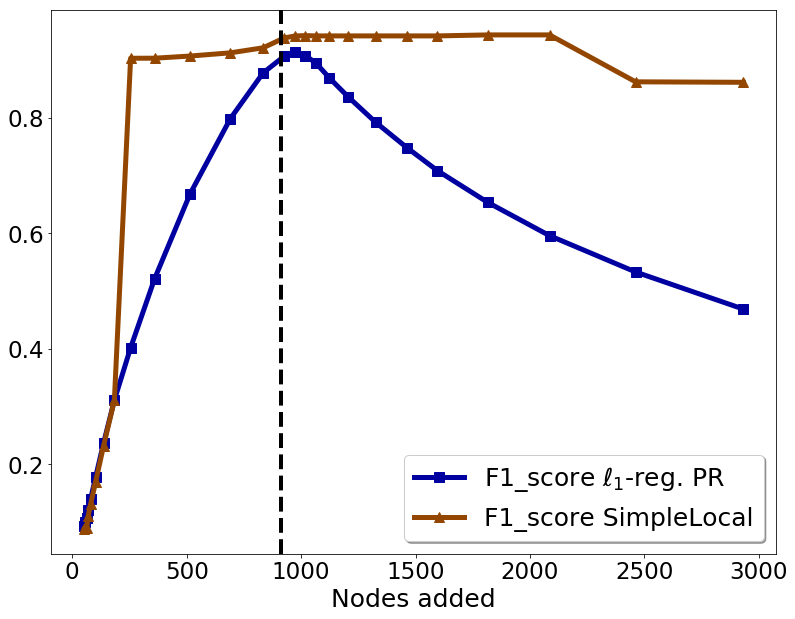

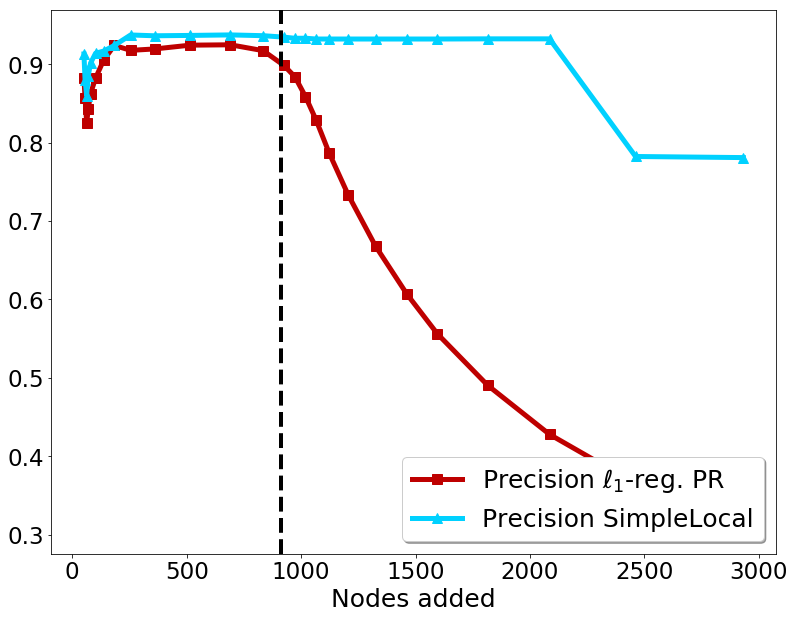

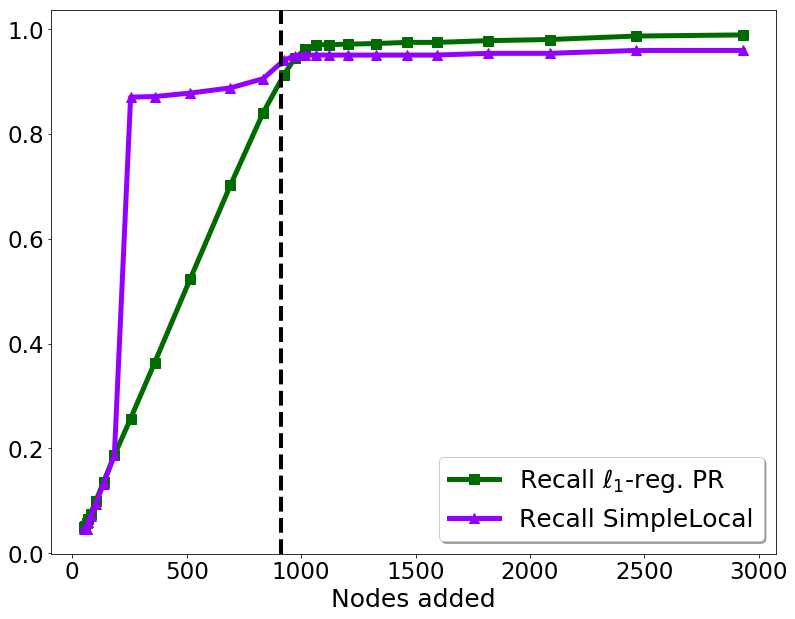

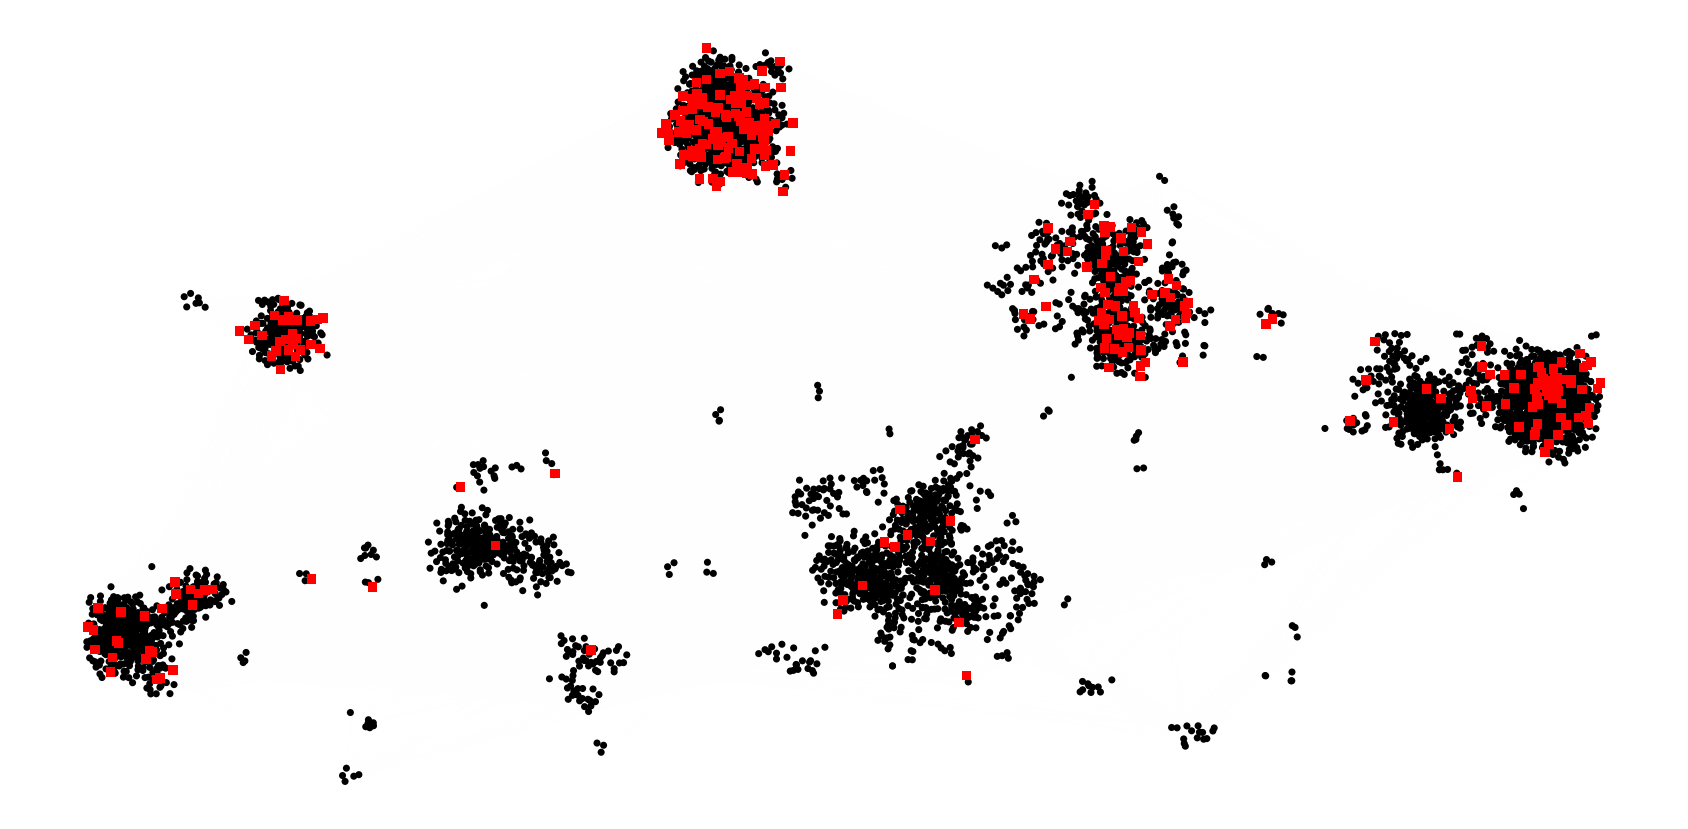

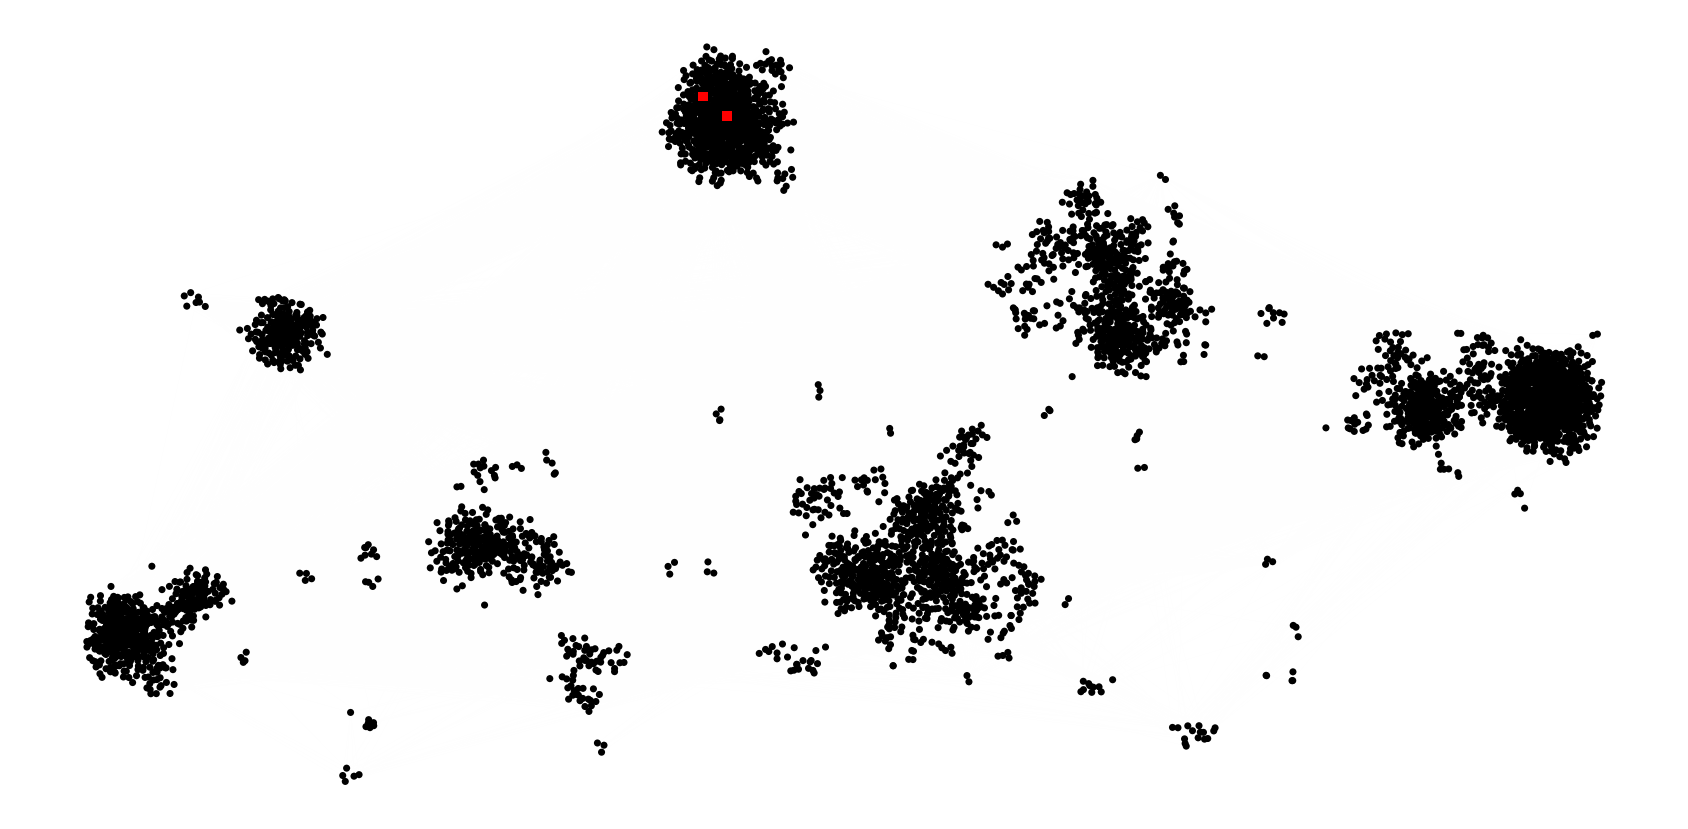

In [5]:
g = GraphLocal('../datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml('../datasets/JohnsHopkins.graphml')

target_cluster = []
counter = 0
for node in g_nx.nodes():
    if g_nx.node[node]['year'] == 2009.0:
        target_cluster.append(counter)
    counter += 1
    
ld_coord = np.loadtxt('../datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]

# Set teleportation parameter
alpha = g.compute_conductance(target_cluster)**2

# Set reference node for algorithm
ref_node = target_cluster[0]

d = g.d
n = g._num_vertices

# Stagewise algorithm
start = time.time()

Conductance = []
TPR = []
FPR = []
FDR = []
Pos_Size = []
F1score = []
Precision = []
Recall = []

Conductance_sl = []
TPR_sl = []
FPR_sl = []
FDR_sl = []
Pos_Size_sl = []
F1score_sl = []
Precision_sl = []
Recall_sl = []

vol_G = np.sum(g.d)

rho_list = list(np.geomspace(1.0e-4, 1.0e-18, 200, endpoint=True))

cardinalities = []

counter = 1

for rho in rho_list:

    output = approximate_PageRank(g,ref_node,method='l1reg-rand',alpha=alpha,rho=rho,normalize=False,normalized_objective=False,epsilon=1.0e-10,iterations=1000000,cpp=True)
    recovered_cluster = output[0]
        
    recovered_cluster_sweep = recovered_cluster #sweep_cut(g,(output[0],output[1]))[0]
    
    cardinalities.append(len(recovered_cluster))

    output_sl = flow_clustering(g,recovered_cluster_sweep,method="sl", delta=0.0001)[0]

    conductance = g.compute_conductance(recovered_cluster_sweep)
    Conductance.append(conductance)

    conductance = g.compute_conductance(output_sl)
    Conductance_sl.append(conductance)

    true_pos = np.intersect1d(recovered_cluster_sweep, target_cluster)
    true_pos_rate = len(true_pos)/len(target_cluster)

    true_pos_sl = np.intersect1d(output_sl, target_cluster)
    true_pos_rate_sl = len(true_pos_sl)/len(target_cluster)

    false_pos = np.setdiff1d(recovered_cluster_sweep, target_cluster)
    if len(recovered_cluster_sweep) == 0:
        false_disc_rate = len(false_pos)
    else:
        false_disc_rate = len(false_pos)/len(recovered_cluster_sweep)
    false_pos_rate = len(false_pos)/(n-len(target_cluster))

    false_pos_sl = np.setdiff1d(output_sl, target_cluster)
    if len(output_sl) == 0:
        false_disc_rate_sl = len(false_pos_sl)
    else:
        false_disc_rate_sl = len(false_pos_sl)/len(output_sl)
    false_pos_rate_sl = len(false_pos_sl)/(n-len(target_cluster))

    TPR.append(true_pos_rate)
    FDR.append(false_disc_rate)
    FPR.append(false_pos_rate)
    Pos_Size.append(len(recovered_cluster_sweep)) 
    temp = np.zeros(n)
    temp[recovered_cluster_sweep] = 1
    temp2 = np.zeros(n)
    temp2[target_cluster] = 1
    F1score.append(f1_score(temp2,temp))
    Precision.append(precision_score(temp2,temp))
    Recall.append(recall_score(temp2,temp))

    TPR_sl.append(true_pos_rate_sl)
    FDR_sl.append(false_disc_rate_sl)
    FPR_sl.append(false_pos_rate_sl)
    Pos_Size_sl.append(len(output_sl))   
    temp = np.zeros(n)
    temp[output_sl] = 1
    temp2 = np.zeros(n)
    temp2[target_cluster] = 1
    F1score_sl.append(f1_score(temp2,temp))
    Precision_sl.append(precision_score(temp2,temp))
    Recall_sl.append(recall_score(temp2,temp))
    
    if counter == 20:
        store_spectral = recovered_cluster_sweep
        store_sl = output_sl
        
    if true_pos_rate >0.9999999:
        break
        
    if np.sum(g.d[recovered_cluster]) > g.vol_G/2:
        break
    
    counter += 1

end = time.time()

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, F1score, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, F1score_sl, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_f1score_sl_plots_2009.pdf', format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, Precision, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, Precision_sl, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_precision_sl_plots_2009.pdf', format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, Recall, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, Recall_sl, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_recall_sl_plots_2009.pdf', format='pdf',bbox_inches='tight')

store_spectral = store_spectral[0:int(len(store_spectral)/4)]

temp = np.ones(g._num_vertices)
temp[store_spectral] = 2

node_colors = ['black' for i in range(g._num_vertices)]
for i in store_spectral:
    node_colors[i] = 'red'

nodesize_list = 50*np.ones(g._num_vertices)
nodesize_list[store_spectral] = 90

nodemarker_list = ['o'] * g._num_vertices
for i in store_spectral:
    nodemarker_list[i] = 's'
    
nodeorder_list = [1 for i in range(g._num_vertices)]
for i in store_spectral:
    nodeorder_list[i] = 2

drawing = g.draw_groups(pos,temp,figsize=(30,15),edgealpha=0.003,node_color_list=node_colors,nodesize_list=nodesize_list,nodemarker_list=nodemarker_list,nodeorder_list=nodeorder_list)

# drawing.fig.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_input_sl_2009.png', format='png',bbox_inches='tight')

output_sl = flow_clustering(g,store_spectral,method="sl", delta=0.0001)[0]

node_colors = ['black' for i in range(g._num_vertices)]
for i in output_sl:
    node_colors[i] = 'red'

temp = np.ones(g._num_vertices)
temp[output_sl] = 4

nodesize_list = 50*np.ones(g._num_vertices)
nodesize_list[output_sl] = 90

nodemarker_list = ['o'] * g._num_vertices
for i in output_sl:
    nodemarker_list[i] = 's'
    
nodeorder_list = [1 for i in range(g._num_vertices)]
for i in output_sl:
    nodeorder_list[i] = 2

drawing = g.draw_groups(pos,temp,figsize=(30,15),edgealpha=0.003,node_color_list=node_colors,nodesize_list=nodesize_list,nodemarker_list=nodemarker_list,nodeorder_list=nodeorder_list)

# drawing.fig.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_sl_2009.png', format='png',bbox_inches='tight',nodeorder_list=nodeorder_list)

## JH, majorIndex 217, LFI

In [ ]:
g = GraphLocal('../datasets/JohnsHopkins.graphml','graphml')

g_nx = nx.read_graphml('../datasets/JohnsHopkins.graphml')

target_cluster = []
counter = 0
for node in g_nx.nodes():
    if g_nx.node[node]['majorIndex'] == 217.0:
        target_cluster.append(counter)
    counter += 1
    
ld_coord = np.loadtxt('../datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])
pos = np.zeros((g._num_vertices,2))
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]

# Set teleportation parameter
alpha = g.compute_conductance(target_cluster)**2

# Set reference node for algorithm
ref_node = target_cluster[0]

d = g.d
n = g._num_vertices

# Stagewise algorithm
start = time.time()

Conductance = []
TPR = []
FPR = []
FDR = []
Pos_Size = []
F1score = []
Precision = []
Recall = []

Conductance_sl = []
TPR_sl = []
FPR_sl = []
FDR_sl = []
Pos_Size_sl = []
F1score_sl = []
Precision_sl = []
Recall_sl = []

vol_G = np.sum(g.d)

rho_list = list(np.geomspace(1.0e-4, 1.0e-18, 200, endpoint=True))

cardinalities = []

counter = 1

for rho in rho_list:

    output = approximate_PageRank(g,ref_node,method='l1reg-rand',alpha=alpha,rho=rho,normalize=False,normalized_objective=False,epsilon=1.0e-10,iterations=1000000,cpp=True)
    recovered_cluster = output[0]
        
    recovered_cluster_sweep = recovered_cluster #sweep_cut(g,(output[0],output[1]))[0]
    
    cardinalities.append(len(recovered_cluster))

    output_sl = flow_clustering(g,recovered_cluster_sweep,method="sl", delta=0.000)[0]

    conductance = g.compute_conductance(recovered_cluster_sweep)
    Conductance.append(conductance)

    conductance = g.compute_conductance(output_sl)
    Conductance_sl.append(conductance)

    true_pos = np.intersect1d(recovered_cluster_sweep, target_cluster)
    true_pos_rate = len(true_pos)/len(target_cluster)

    true_pos_sl = np.intersect1d(output_sl, target_cluster)
    true_pos_rate_sl = len(true_pos_sl)/len(target_cluster)

    false_pos = np.setdiff1d(recovered_cluster_sweep, target_cluster)
    if len(recovered_cluster_sweep) == 0:
        false_disc_rate = len(false_pos)
    else:
        false_disc_rate = len(false_pos)/len(recovered_cluster_sweep)
    false_pos_rate = len(false_pos)/(n-len(target_cluster))

    false_pos_sl = np.setdiff1d(output_sl, target_cluster)
    if len(output_sl) == 0:
        false_disc_rate_sl = len(false_pos_sl)
    else:
        false_disc_rate_sl = len(false_pos_sl)/len(output_sl)
    false_pos_rate_sl = len(false_pos_sl)/(n-len(target_cluster))

    TPR.append(true_pos_rate)
    FDR.append(false_disc_rate)
    FPR.append(false_pos_rate)
    Pos_Size.append(len(recovered_cluster_sweep)) 
    temp = np.zeros(n)
    temp[recovered_cluster_sweep] = 1
    temp2 = np.zeros(n)
    temp2[target_cluster] = 1
    F1score.append(f1_score(temp2,temp))
    Precision.append(precision_score(temp2,temp))
    Recall.append(recall_score(temp2,temp))

    TPR_sl.append(true_pos_rate_sl)
    FDR_sl.append(false_disc_rate_sl)
    FPR_sl.append(false_pos_rate_sl)
    Pos_Size_sl.append(len(output_sl))   
    temp = np.zeros(n)
    temp[output_sl] = 1
    temp2 = np.zeros(n)
    temp2[target_cluster] = 1
    F1score_sl.append(f1_score(temp2,temp))
    Precision_sl.append(precision_score(temp2,temp))
    Recall_sl.append(recall_score(temp2,temp))
    
    if counter == 10:
        store_spectral = recovered_cluster_sweep
        store_sl = output_sl
        
    if true_pos_rate >0.9999999:
        break
        
    if np.sum(g.d[recovered_cluster]) > g.vol_G/2:
        break
    
    counter += 1

end = time.time()

# Plot results
f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, F1score, 'k', color='#0000A1', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, F1score_sl, 'k', color='#934600', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['F1_score $\ell_1$-reg. PR', 'F1_score SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_f1score_sl_plots_217.pdf', format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, Precision, 'k', color='#BE0000', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, Precision_sl, 'k', color='#00D1FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['Precision $\ell_1$-reg. PR', 'Precision SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_precision_sl_plots_217.pdf', format='pdf',bbox_inches='tight')

f = plt.figure(figsize=(13, 10))

plt.plot(cardinalities, Recall, 'k', color='#006C00', marker="s",markersize=10,linewidth=5)
plt.plot(cardinalities, Recall_sl, 'k', color='#9400FF', marker="^",markersize=10,linewidth=5)
plt.axvline(x=len(target_cluster),linestyle='--',color='black',linewidth=4)

plt.legend(['Recall $\ell_1$-reg. PR', 'Recall SimpleLocal'], loc='lower right', fancybox=True, shadow=True ,fontsize=25)

plt.xlabel('Nodes added', fontsize=25)

plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

plt.show()

# f.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_recall_sl_plots_217.pdf', format='pdf',bbox_inches='tight')

store_spectral = store_spectral[0:int(len(store_spectral)/5)]

temp = np.ones(g._num_vertices)
temp[store_spectral] = 2

node_colors = ['black' for i in range(g._num_vertices)]
for i in store_spectral:
    node_colors[i] = 'blue'

nodesize_list = 50*np.ones(g._num_vertices)
nodesize_list[store_spectral] = 90

nodemarker_list = ['o'] * g._num_vertices
for i in store_spectral:
    nodemarker_list[i] = 's'
    
nodeorder_list = [1 for i in range(g._num_vertices)]
for i in store_spectral:
    nodeorder_list[i] = 2

drawing = g.draw_groups(pos,temp,figsize=(30,15),edgealpha=0.003,node_color_list=node_colors,nodesize_list=nodesize_list,nodemarker_list=nodemarker_list,nodeorder_list=nodeorder_list)

# drawing.fig.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_input_sl_217.png', format='png',bbox_inches='tight')

output_sl = flow_clustering(g,store_spectral,method="sl", delta=0.0001)[0]

node_colors = ['black' for i in range(g._num_vertices)]
for i in output_sl:
    node_colors[i] = 'blue'

temp = np.ones(g._num_vertices)
temp[output_sl] = 4

nodesize_list = 50*np.ones(g._num_vertices)
nodesize_list[output_sl] = 90

nodemarker_list = ['o'] * g._num_vertices
for i in output_sl:
    nodemarker_list[i] = 's'
    
nodeorder_list = [1 for i in range(g._num_vertices)]
for i in output_sl:
    nodeorder_list[i] = 2

drawing = g.draw_groups(pos,temp,figsize=(30,15),edgealpha=0.003,node_color_list=node_colors,nodesize_list=nodesize_list,nodemarker_list=nodemarker_list,nodeorder_list=nodeorder_list)

# drawing.fig.savefig('/Users/kimonfountoulakis/Desktop/BoxSync/University/Waterloo/assistantProfessor/papers/reviewPaperOnFlowAlgorithms/figures/jh_sl_217.png', format='png',bbox_inches='tight',nodeorder_list=nodeorder_list)

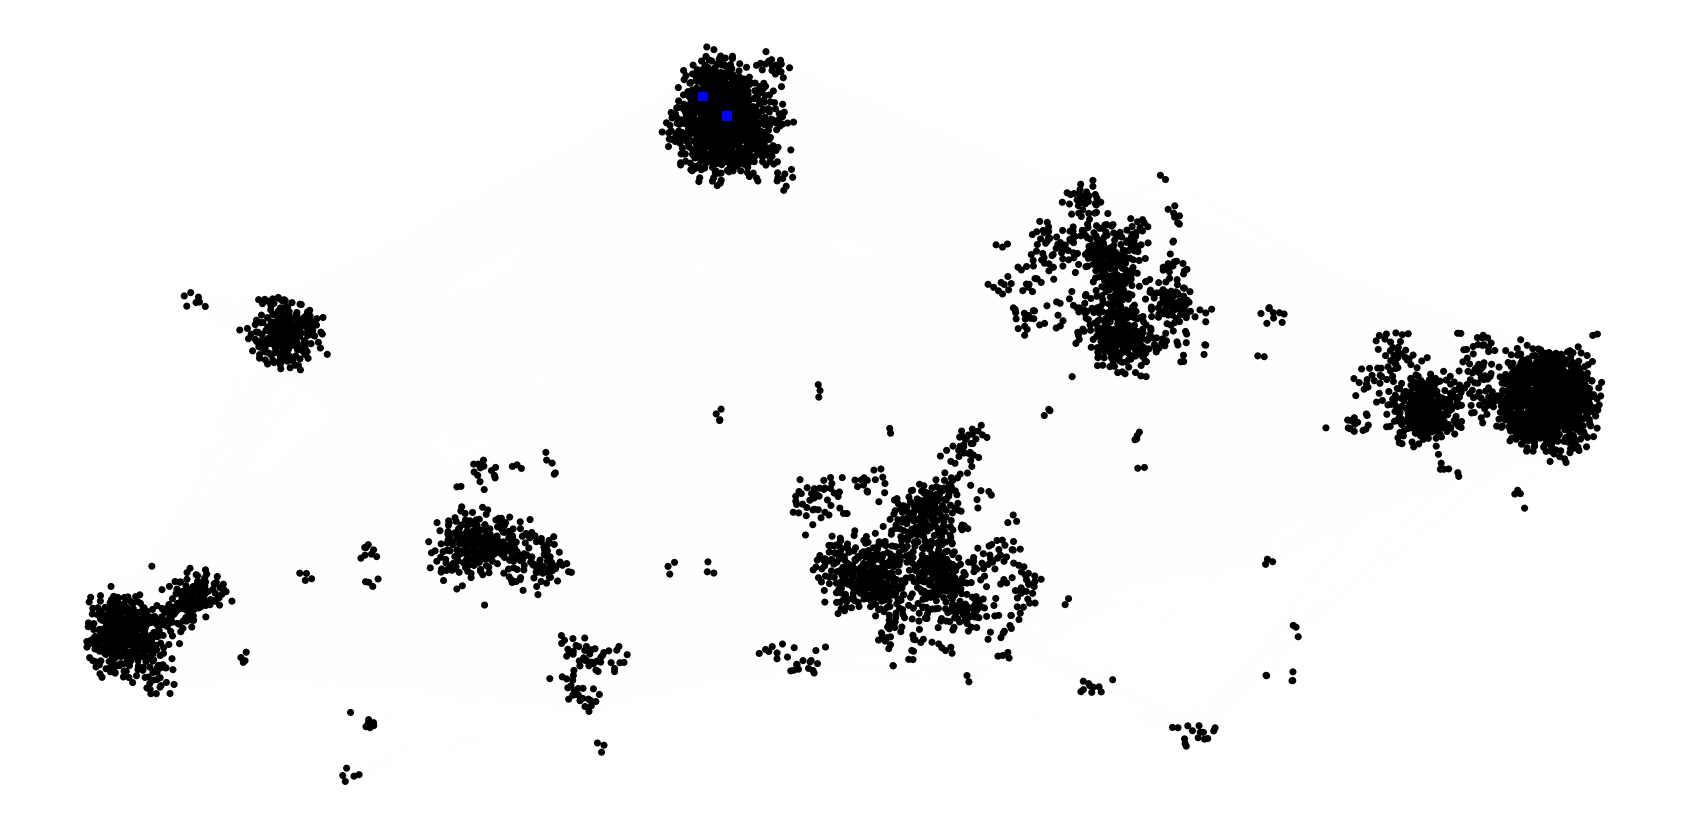

In [11]:
output_sl_ = flow_clustering(g,store_spectral,method="sl", delta=0.001)
output_sl = output_sl_[0]

node_colors = ['black' for i in range(g._num_vertices)]
for i in output_sl:
    node_colors[i] = 'blue'

temp = np.ones(g._num_vertices)
temp[output_sl] = 4

nodesize_list = 50*np.ones(g._num_vertices)
nodesize_list[output_sl] = 90

nodemarker_list = ['o'] * g._num_vertices
for i in output_sl:
    nodemarker_list[i] = 's'
    
nodeorder_list = [1 for i in range(g._num_vertices)]
for i in output_sl:
    nodeorder_list[i] = 2

drawing = g.draw_groups(pos,temp,figsize=(30,15),edgealpha=0.003,node_color_list=node_colors,nodesize_list=nodesize_list,nodemarker_list=nodemarker_list,nodeorder_list=nodeorder_list)

